# Packages

In [1]:
# Data and Maths
import pandas as pd
import geopandas as gpd
import numpy as np
import math
from dataclasses import dataclass

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
import scipy.stats as stats
from scipy.stats import binom, norm
import pymc as pm
import arviz as az
RANDOM_SEED = 42
import random

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Pre-processing

In [2]:
@dataclass
class DataContainer:
    file_path: str
    raw_data: pd.DataFrame = None
    data: pd.DataFrame = None

class BasePreprocessor():
    def __init__(self, data_container: DataContainer) -> None:
        self.data_container = data_container
    
    def preprocess(self, keep_raw: bool, dtype=None, na_values=None) -> None:
        self._load_csv_to_df(self.data_container, keep_raw, dtype, na_values)

    def _load_csv_to_df(self, container: DataContainer, keep_raw: bool, dtype=None, na_values=None) -> None:
        try:
            container.data = pd.read_csv(container.file_path, dtype=dtype, na_values=na_values)
            if keep_raw:
                container.raw_data = container.data.copy()
        except FileNotFoundError as e:
            raise FileNotFoundError(f"File not found: {container.file_path}") from e
    
    def _rename_df_columns(self, column_mapper: dict) -> None:
        self.data_container.data = self.data_container.data.rename(columns=column_mapper)

    def _select_df_columns(self, columns: list) -> None:
        self.data_container.data = self.data_container.data[columns]

    def _drop_duplicate_rows(self, subset) -> None:
        self.data_container.data.drop_duplicates(subset=subset, keep='first', inplace=True)
    
    def _drop_duplicate_rows_by_index(self) -> None:
        self.data_container.data = self.data_container.data[~self.data_container.data.index.duplicated(keep='first')]

    def _set_df_index(self, index_name: str, drop: bool) -> None:
        self.data_container.data = self.data_container.data.set_index(index_name, drop=drop)
    
    def _apply_dtypes(self, start_col: int, end_col: int) -> dict:
        dtypes = {i: str for i in range(start_col)} # first 'first' columns as strings
        dtypes.update({i: float for i in range(start_col, end_col)}) # 'last' columns is currently hard coded. Float is needed for NaNs
        return dtypes

class CarVan2011DataPreprocessor(BasePreprocessor):
    def preprocess(self, keep_raw: bool) -> pd.DataFrame:
        super().preprocess(keep_raw)
        self._rename_df_columns({
            'GEO_CODE': 'LSOA11CD',
            'GEO_LABEL': 'LSOA11NM',
            'Car or van availability : Sum of all cars or vans - Unit : Cars or vans': 'cars',
            'Car or van availability : No cars or vans in household - Unit : Households': 'households_without_cars',
            'Car or van availability : Total\ Car or van availability - Unit : Households': 'households'
            }
        )
        self._drop_duplicate_rows('LSOA11CD')
        self._set_df_index('LSOA11CD', drop=True)
        self._select_df_columns(['LSOA11NM', 'cars', 'households', 'households_without_cars'])
        self._drop_duplicate_rows_by_index()
        print('Pre-processing complete')
        return self.data_container.data

class CarVan2021DataPreprocessor(BasePreprocessor):  
    def __init__(self, data_container: DataContainer, lsoa_lookup_file_name: str) -> None:
        super().__init__(data_container)
        self.lsoa_lookup_file_name = lsoa_lookup_file_name 

    def preprocess(self, keep_raw: bool) -> pd.DataFrame:
        super().preprocess(keep_raw)
        self._count_number_of_cars()
        self._condense_data()
        self._reindex_data()
        self._drop_duplicate_rows_by_index()
        print('Pre-processing complete')
        return self.data_container.data

    def _count_number_of_cars(self) -> None:
        self.data_container.raw_data['cars'] = self.data_container.raw_data['Observation'] * self.data_container.raw_data['Car or van availability (5 categories) Code']

    def _condense_data(self) -> None:
        self.data_container.data = (
            pd.DataFrame(index=self.data_container.raw_data['Lower Layer Super Output Areas Code'].unique(), columns=['LSOA21CD', 'LSOA21NM', 'cars', 'houses_without_cars'])
            .assign(
                LSOA21CD=lambda df: df.index, 
                LSOA21NM=self.data_container.raw_data['Lower Layer Super Output Areas'].unique(),
                cars=self.data_container.raw_data.groupby('Lower Layer Super Output Areas Code')['cars'].sum(),
                houses_without_cars=self.data_container.raw_data.loc[self.data_container.raw_data['Car or van availability (5 categories) Code'] == 0, ['Lower Layer Super Output Areas Code', 'Observation']].set_index('Lower Layer Super Output Areas Code')
            )
        )

    def _reindex_data(self) -> None:
        lsoa_lookup = pd.read_csv(self.lsoa_lookup_file_name)
        data = self.data_container.data
        self.data_container.data = (
            data
            .merge(lsoa_lookup[['LSOA11CD', 'LSOA21CD']], on='LSOA21CD', how='right')
            .assign(cars=lambda df: df.groupby('LSOA11CD')['cars'].transform('sum'))
            .drop(columns=['LSOA21CD'])
        )
        self._set_df_index('LSOA11CD', drop=True)

class VehicleRegistrationsDataPreprocessor(BasePreprocessor):
    def __init__(self, data_container: DataContainer):
        super().__init__(data_container)
        self.data_container = data_container
    
    def preprocess(self, keep_raw: bool) -> pd.DataFrame:
        super().preprocess(keep_raw, dtype=self._apply_dtypes(5, 57), na_values=['[c]', '[x]'])
        self.data_container.data = self._preprocess_by_bodytype('Cars') + self._preprocess_by_bodytype('Other body types')
        self._drop_duplicate_rows_by_index()
        self.data_container.data = self.data_container.data.drop('Miscellaneous')
        print('Pre-processing complete')
        return self.data_container.data
    
    def _preprocess_by_bodytype(self, bodytype: str) -> pd.DataFrame:
        bodytype_data = self.data_container.data.query("BodyType == '" + bodytype + "' & Keepership == 'Private' & LicenceStatus == 'Licensed'")
        bodytype_data = bodytype_data.drop(columns = ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM'])
        bodytype_data = bodytype_data.set_index('LSOA11CD', drop=True)
        return bodytype_data
    
class EVRegistrationsDataPreprocessor(BasePreprocessor):
    def __init__(self, data_container: DataContainer, fuel_type: str):
        super().__init__(data_container)
        self.data_container = data_container
        self.fuel_type = fuel_type
    
    def preprocess(self, keep_raw: bool) -> pd.DataFrame:
        super().preprocess(keep_raw, dtype=self._apply_dtypes(4, 56), na_values=['[c]', '[x]'])
        self._filter_data()
        self._set_df_index('LSOA11CD', drop=True)
        self._split_by_fuel_type()
        self._drop_duplicate_rows_by_index()
        print('Pre-processing complete')
        return self.data_container.data
    
    def _filter_data(self):
        self.data_container.data = (
            self.data_container.data
            .query("Keepership == 'Private'")
            .drop(columns=['Keepership', 'LSOA11NM'])
        )
    
    def _split_by_fuel_type(self):
        self.data_container.data = (
            self.data_container.data
            .query("Fuel == '" + self.fuel_type + "' or Fuel.isnull()")
            .drop(columns=["Fuel"])
        )

class HouseDataPreprocessor(BasePreprocessor):
    def __init__(self, data_container: DataContainer, lsoa_lookup_file_name: str) -> None:
        super().__init__(data_container)
        self.lsoa_lookup_file_name = lsoa_lookup_file_name 
    
    def preprocess(self, keep_raw: bool, dtype=None, na_values=None) -> pd.DataFrame:
        super().preprocess(keep_raw, dtype, na_values)
        lsoa_lookup = pd.read_csv(self.lsoa_lookup_file_name)
        self.data_container.data = (
            self.data_container.data
            .rename(columns={'Lower layer Super Output Areas Code':'LSOA21CD', 'Lower layer Super Output Areas':'LSOA21NM', 'Observation':'households'})
            .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LSOA21CD']], on = 'LSOA21CD', how='outer')
            .drop(columns=['LSOA21NM'])
            .set_index('LSOA11CD')
        )
        self._drop_duplicate_rows_by_index()
        print('Pre-processing complete')
        return self.data_container.data

class AccommodationTypeDataPreprocessor(BasePreprocessor):
    def __init__(self, data_container: DataContainer, lsoa_lookup_file_name: str) -> None:
        super().__init__(data_container)
        self.lsoa_lookup_file_name = lsoa_lookup_file_name 
    
    def preprocess(self, keep_raw: bool, dtype=None, na_values=None) -> pd.DataFrame:
        super().preprocess(keep_raw, dtype, na_values)
        lsoa_lookup = pd.read_csv(self.lsoa_lookup_file_name)
        self.data_container.data = (
            self.data_container.data
            .rename(columns={'Lower layer Super Output Areas Code':'LSOA21CD', 'Lower layer Super Output Areas':'LSOA21NM', 'Accommodation type (8 categories)':'accommodation_type'})
            .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LSOA21CD']], on = 'LSOA21CD', how='outer')
            .drop(columns=['LSOA21NM', 'Accommodation type (8 categories) Code'])
            .set_index('LSOA11CD')
        )
        print('Pre-processing complete')
        return self.data_container.data

In [3]:
# Create Data Containers
car_van_2011_container = DataContainer(file_path='../Data/Vehicle/CarsAndVans2011.csv')
car_van_2021_container = DataContainer(file_path='../Data/Vehicle/CarsAndVans2021.csv')
vehicle_registrations_container = DataContainer(file_path='../Data/Vehicle/df_VEH0125.csv')
bev_registrations_container = DataContainer(file_path='../Data/Vehicle/df_VEH0145.csv')
phev_registrations_container = DataContainer(file_path='../Data/Vehicle/df_VEH0145.csv')
house_2021_container = DataContainer(file_path='../Data/Demographic/LSOA_households.csv')
accomodation_type_2021_container = DataContainer(file_path='../Data/Demographic/LSOA_accommodation_type.csv')

# Load and preprocess data
lsoa_lookup_file = '../data/spatial/LSOA/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv'
car_van_2011_data_preprocessor = CarVan2011DataPreprocessor(car_van_2011_container)
car_van_2021_data_preprocessor = CarVan2021DataPreprocessor(car_van_2021_container, lsoa_lookup_file)
vehicle_registrations_data_preprocessor = VehicleRegistrationsDataPreprocessor(vehicle_registrations_container)
bev_registrations_data_preprocessor = EVRegistrationsDataPreprocessor(bev_registrations_container, fuel_type='Battery electric')
phev_registrations_data_preprocessor = EVRegistrationsDataPreprocessor(phev_registrations_container, fuel_type='Plug-in hybrid electric (petrol)')
house_2021_data_preprocessor = HouseDataPreprocessor(house_2021_container, lsoa_lookup_file)
accomodation_type_2021_data_preprocessor = AccommodationTypeDataPreprocessor(accomodation_type_2021_container, lsoa_lookup_file)

car_van_2011_data = car_van_2011_data_preprocessor.preprocess(keep_raw=False)
car_van_2021_data = car_van_2021_data_preprocessor.preprocess(keep_raw=True)
vehicle_registrations_data = vehicle_registrations_data_preprocessor.preprocess(keep_raw=False)
bev_registrations_data = bev_registrations_data_preprocessor.preprocess(keep_raw=True)
phev_registrations_data = phev_registrations_data_preprocessor.preprocess(keep_raw=True)
house_2021_data = house_2021_data_preprocessor.preprocess(keep_raw=False)
accomodation_type_2021_data = accomodation_type_2021_data_preprocessor.preprocess(keep_raw=False)

Pre-processing complete
Pre-processing complete
Pre-processing complete
Pre-processing complete
Pre-processing complete
Pre-processing complete
Pre-processing complete


In [4]:
car_van_2021_data.head()

,LSOA21NM,cars,houses_without_cars
LSOA11CD,,,
E01000001,City of London 001A,331,555
E01000002,City of London 001B,296,578
E01000003,City of London 001C,220,826
E01000005,City of London 001E,119,375
E01000006,Barking and Dagenham 016A,516,183


In [5]:
vehicle_registrations_data.head()

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
95AA01S1,136.0,134.0,135.0,142.0,155.0,146.0,146.0,158.0,162.0,159.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95AA01S2,1491.0,1483.0,1489.0,1516.0,1504.0,1498.0,1517.0,1533.0,1499.0,1494.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95AA01S3,1176.0,1167.0,1174.0,1195.0,1171.0,1151.0,1175.0,1177.0,1182.0,1199.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95AA02W1,774.0,776.0,760.0,759.0,765.0,779.0,796.0,788.0,790.0,786.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95AA03W1,852.0,850.0,853.0,853.0,856.0,843.0,843.0,836.0,830.0,825.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Find Common LSOA Codes and Filter Data

In [6]:
def intersection_of_lists(*args):
    """
    Returns the intersection of all provided lists.

    Args:
    *args: Variable length argument of lists.

    Returns:
    List containing the intersection of all provided lists.
    """
    
    # If no lists are provided, return an empty list
    if not args:
        return []

    # Start with the set of the first list
    result_set = set(args[0])

    # Iterate over the remaining lists, updating the result_set
    for lst in args[1:]:
        result_set &= set(lst)

    return list(result_set)

In [7]:
accomodation_type_2021_data

,LSOA21CD,accommodation_type,Observation
LSOA11CD,,,
E01000001,E01000001,Detached,0
E01000001,E01000001,Semi-detached,3
E01000001,E01000001,Terraced,13
E01000001,E01000001,In a purpose-built block of flats or tenement,803
E01000001,E01000001,"Part of a converted or shared house, including...",0
...,...,...,...
W01001061,W01002040,In a purpose-built block of flats or tenement,198
W01001061,W01002040,"Part of a converted or shared house, including...",3
W01001061,W01002040,"Part of another converted building, for exampl...",0


In [8]:
common_lsoas = intersection_of_lists(
    car_van_2011_data.index,
    car_van_2021_data.index,
    vehicle_registrations_data.index,
    bev_registrations_data.index,
    phev_registrations_data.index,
    house_2021_data.index,
    accomodation_type_2021_data.index
)

car_van_2011_data = car_van_2011_data.loc[common_lsoas].sort_index()
car_van_2021_data = car_van_2021_data.loc[common_lsoas].sort_index()
vehicle_registrations_data = vehicle_registrations_data.loc[common_lsoas].sort_index()
bev_registrations_data = bev_registrations_data.loc[common_lsoas].sort_index()
phev_registrations_data = phev_registrations_data.loc[common_lsoas].sort_index()
house_2021_data = house_2021_data.loc[common_lsoas].sort_index()
accomodation_type_2021_data = accomodation_type_2021_data.loc[common_lsoas].sort_index()

In [9]:
vehicle_registrations_data

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01000001,301.0,304.0,313.0,325.0,327.0,325.0,321.0,322.0,322.0,329.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01000002,270.0,274.0,268.0,269.0,274.0,278.0,274.0,280.0,288.0,288.0,...,320.0,319.0,317.0,328.0,324.0,328.0,328.0,323.0,301.0,303.0
E01000003,165.0,170.0,178.0,177.0,170.0,167.0,164.0,180.0,177.0,181.0,...,193.0,201.0,203.0,206.0,205.0,206.0,206.0,203.0,206.0,207.0
E01000005,97.0,95.0,98.0,102.0,NaN,97.0,99.0,100.0,NaN,NaN,...,NaN,NaN,NaN,115.0,119.0,NaN,NaN,NaN,NaN,NaN
E01000006,499.0,500.0,501.0,505.0,492.0,478.0,479.0,491.0,501.0,499.0,...,504.0,504.0,508.0,506.0,519.0,527.0,528.0,540.0,514.0,501.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W01001951,326.0,331.0,329.0,329.0,327.0,334.0,338.0,331.0,326.0,325.0,...,351.0,369.0,364.0,364.0,355.0,359.0,370.0,383.0,380.0,361.0
W01001953,701.0,684.0,689.0,684.0,686.0,695.0,698.0,691.0,678.0,683.0,...,593.0,593.0,604.0,578.0,586.0,575.0,577.0,573.0,558.0,564.0
W01001954,914.0,910.0,917.0,919.0,930.0,926.0,939.0,938.0,923.0,928.0,...,903.0,906.0,895.0,895.0,896.0,892.0,894.0,897.0,895.0,888.0


# Estimating EV Adoption in LSOAs

Need to turn this into a class

In [188]:
vehicle_registrations_data.T.iloc[::-1].iloc[::-1].T

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01000001,301.0,304.0,313.0,325.0,327.0,325.0,321.0,322.0,322.0,329.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01000002,270.0,274.0,268.0,269.0,274.0,278.0,274.0,280.0,288.0,288.0,...,320.0,319.0,317.0,328.0,324.0,328.0,328.0,323.0,301.0,303.0
E01000003,165.0,170.0,178.0,177.0,170.0,167.0,164.0,180.0,177.0,181.0,...,193.0,201.0,203.0,206.0,205.0,206.0,206.0,203.0,206.0,207.0
E01000005,97.0,95.0,98.0,102.0,NaN,97.0,99.0,100.0,NaN,NaN,...,NaN,NaN,NaN,115.0,119.0,NaN,NaN,NaN,NaN,NaN
E01000006,499.0,500.0,501.0,505.0,492.0,478.0,479.0,491.0,501.0,499.0,...,504.0,504.0,508.0,506.0,519.0,527.0,528.0,540.0,514.0,501.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W01001951,326.0,331.0,329.0,329.0,327.0,334.0,338.0,331.0,326.0,325.0,...,351.0,369.0,364.0,364.0,355.0,359.0,370.0,383.0,380.0,361.0
W01001953,701.0,684.0,689.0,684.0,686.0,695.0,698.0,691.0,678.0,683.0,...,593.0,593.0,604.0,578.0,586.0,575.0,577.0,573.0,558.0,564.0
W01001954,914.0,910.0,917.0,919.0,930.0,926.0,939.0,938.0,923.0,928.0,...,903.0,906.0,895.0,895.0,896.0,892.0,894.0,897.0,895.0,888.0


In [230]:
class RegistrationInterpolator:
    def __init__(self, sample_rate=4) -> None:
        self.registration_data = None
        self.sample_rate = sample_rate

    # Interpolates missing registration data
    def interpolate(self, registration_data: pd.DataFrame) -> pd.DataFrame:
        self.registration_data = registration_data.T.iloc[::-1]
        interpolated_df = self.registration_data.apply(self._interpolate_column, axis=0)
        # interpolated_df = interpolated_df.fillna(0)
        interpolated_df = interpolated_df.astype('Int64')
        return interpolated_df.iloc[::-1].T
    
    def _interpolate_column(self, col) -> pd.Series:
        dates = self._calculate_date_range(self._calculate_t0(col), self._calculate_t_present(col))
        mask = ~col.isna().values
        if mask.any():
            xp = dates[mask]
            fp = col[mask]
            x = dates
            interpolated_array = np.round(np.interp(x, xp, fp))
            interpolated_series = pd.Series(data=interpolated_array, index=col.index)
        else:
            interpolated_series = pd.Series(data=np.nan, index=col.index)
        return interpolated_series

    # apply_dtypes converts select columns from str to float values
    def _apply_dtypes(first_col: int, last_col: int) -> dict:
        dtypes = {i: str for i in range(first_col)}  # first 'first' columns as strings
        dtypes.update({i: float for i in range(first_col, last_col)}) # 'last' columns is currently hard coded. Float is needed for NaNs
        return dtypes
    
    def _quarter_to_decimal(self, year: int, quarter: str) -> float:
        """
        Converts a year and quarter to a decimal year representation.
        """
        quarters = {'Q1': 0, 'Q2': 0.25, 'Q3': 0.5, 'Q4': 0.75}
        return year + quarters.get(quarter, 0)

    def _calculate_t0(self, col) -> float:
        year = int(col.head(1).index[0][:4])
        quarter = col.head(1).index[0][-2:]
        return self._quarter_to_decimal(year, quarter)

    def _calculate_t_present(self, col) -> float:
        year = int(col.tail(1).index[0][:4])
        quarter = col.tail(1).index[0][-2:]
        return self._quarter_to_decimal(year, quarter)

    def _convert_dates_to_numeric(self) -> list:
        dates = []
        for date in self.registration_data.index:
            year = int(date[:4])
            quarter = date[-2:]
            dates.append(self._quarter_to_decimal(year, quarter))
        return dates

    # Returns an array of numeric dates between t0 and t1 at a specified sample rate
    def _calculate_date_range(self, t0: float, t1: float) -> list:
        return np.linspace(t0, t1, int((t1-t0)*self.sample_rate) + 1)

In [231]:
registration_interpolator = RegistrationInterpolator()
vehicle_registrations_data_i = registration_interpolator.interpolate(vehicle_registrations_data)
bev_registrations_data_i = registration_interpolator.interpolate(bev_registrations_data)
phev_registrations_data_i = registration_interpolator.interpolate(phev_registrations_data)

# Calculating Error and Uncertainty in Vehicle Registration Data (The quick way)

In [226]:
class VehicleRegistrationRelativeDifferenceCalculator:
    def __init__(
            self, 
            car_van_2011_data: pd.DataFrame, 
            car_van_2021_data: pd.DataFrame, 
            vehicle_registrations_data: pd.DataFrame, 
        ):
        self.car_van_2011_data = car_van_2011_data
        self.car_van_2021_data = car_van_2021_data
        self.vehicle_registrations_data = vehicle_registrations_data.astype(float)
        self.relative_difference_data = None

    def calculate(self, lsoa_list: list) -> pd.DataFrame:
        self._calculate_relative_differences(2011)
        self._calculate_relative_differences(2021)
        self._merge_relative_difference_data()
        return self.relative_difference_data 

    def _calculate_mean_registered_vehicles_for_year(self, year: int) -> None:
        columns = [f"{year} {quarter}" for quarter in ['Q1', 'Q2', 'Q3', 'Q4']]
        df = getattr(self, f'car_van_{year}_data')
        df['registered_vehicles'] = self.vehicle_registrations_data.loc[:, columns].mean(axis=1).round()
    
    def _calculate_absolute_differences(self, year: int) -> None:
        df = getattr(self, f'car_van_{year}_data')
        df['abs_difference'] = df['cars'] - df['registered_vehicles']
    
    def _calculate_relative_differences(self, year: int) -> None:
        self._calculate_mean_registered_vehicles_for_year(year)
        self._calculate_absolute_differences(year)
        df = getattr(self, f'car_van_{year}_data')
        df['relative_difference'] = df['abs_difference'] / df['registered_vehicles']
    
    def _merge_relative_difference_data(self) -> None:
        relative_difference_2011_df = pd.DataFrame({'LSOA11CD': self.car_van_2011_data['relative_difference'].index, 'relative_difference_2011': self.car_van_2011_data['relative_difference'].values})
        relative_difference_2021_df = pd.DataFrame({'LSOA11CD': self.car_van_2021_data['relative_difference'].index, 'relative_difference_2021': self.car_van_2021_data['relative_difference'].values})
        self.relative_difference_data = pd.merge(relative_difference_2011_df, relative_difference_2021_df, how='outer', on='LSOA11CD').set_index('LSOA11CD')
    
class RelativeDifferenceSampleGenerator:
    def __init__(self, relative_difference_data: pd.DataFrame, n_samples: int):
        self.relative_difference_data = relative_difference_data
        self.relative_difference_samples = None
        self.n_samples = n_samples
    
    def generate_samples(self) -> pd.DataFrame:
        self._calculate_relative_difference_mu_and_sigma()
        self._calculate_relative_difference_samples()
        return self.relative_difference_samples

    def _calculate_relative_difference_mu_and_sigma(self) -> None:
        # Priors
        mu_prior = pd.concat([self.relative_difference_data['relative_difference_2011'], self.relative_difference_data['relative_difference_2021']]).mean()
        sigma_prior = pd.concat([self.relative_difference_data['relative_difference_2011'], self.relative_difference_data['relative_difference_2021']]).std()
        var_prior = sigma_prior**2
        precision_prior = 1/var_prior

        # Data
        mu_lsoa = self.relative_difference_data[['relative_difference_2011', 'relative_difference_2021']].mean(axis=1)
        sigma_lsoa = self.relative_difference_data[['relative_difference_2011', 'relative_difference_2021']].std(axis=1)
        var_lsoa = sigma_lsoa**2
        precision_lsoa = 1/var_lsoa

        # Posterior
        mu_post = (2*mu_lsoa*precision_lsoa + mu_prior*precision_prior)/(2*precision_lsoa + precision_prior)
        sigma_post = np.sqrt(1/(2*precision_lsoa + precision_prior))

        self.relative_difference_data['mu_post'] = mu_post
        self.relative_difference_data['sigma_post'] = sigma_post

        # Fill in missing data with mu_prior and sigma_prior (the mean mu and sigma for all LSOAs) if mu_post or sigma_post is NaN
        # This is a result from missing either Census and Registration data in both 2011 and 2021
        self.relative_difference_data.loc[self.relative_difference_data['mu_post'].isna(), 'mu_post'] = mu_lsoa[self.relative_difference_data['mu_post'].isna()]
        self.relative_difference_data.loc[self.relative_difference_data['mu_post'].isna(), 'mu_post'] = mu_prior
        self.relative_difference_data.loc[self.relative_difference_data['sigma_post'].isna(), 'sigma_post'] = sigma_prior

    def _calculate_relative_difference_samples(self) -> None:
        # Initialize an empty DataFrame for samples

        lsoa_list = self.relative_difference_data.index.values
        self.relative_difference_samples = pd.DataFrame(index=np.arange(0, self.n_samples), columns=lsoa_list)

        # Loop over each LSOA to generate samples
        for lsoa in lsoa_list:
            sigma = self.relative_difference_data.sigma_post.loc[lsoa]  # Assuming sigma_post is indexed by LSOA
            mu = self.relative_difference_data.mu_post.loc[lsoa]
            sample_array = np.random.normal(mu, sigma, size=self.n_samples)
            self.relative_difference_samples[lsoa] = sample_array

class VehicleRegistrationEstimator:
    def __init__(self, relative_difference_samples) -> None:
        self.relative_difference_samples = relative_difference_samples
    #     self.registration_data = registration_data
    #     self.adjusted_registration_data = None
    
    def estimate(self, registration_data: pd.DataFrame, quarter: str) -> pd.DataFrame:
        adjusted_registration_data = (1 + self.relative_difference_samples).mul(registration_data[quarter]).round(0).astype('Int64')
        return adjusted_registration_data

In [232]:
vehicle_registration_relative_difference_calculator = VehicleRegistrationRelativeDifferenceCalculator(car_van_2011_data,
                                                                                                      car_van_2021_data,
                                                                                                      vehicle_registrations_data) # Actively choosing not to use interpolated data here

relative_difference_data = vehicle_registration_relative_difference_calculator.calculate(lsoa_list=vehicle_registrations_data.index.to_list())

relative_difference_data.head()

,relative_difference_2011,relative_difference_2021
LSOA11CD,,
E01000001,NaN,0.027950
E01000002,0.369565,0.057143
E01000003,-0.117647,0.279070
E01000005,0.059829,0.202020
E01000006,-0.025540,0.059548


In [233]:
relative_difference_sample_generator = RelativeDifferenceSampleGenerator(relative_difference_data=relative_difference_data,
                                                                         n_samples=1000)

relative_difference_samples = relative_difference_sample_generator.generate_samples()

relative_difference_samples.head()

,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,W01001945,W01001947,W01001948,W01001949,W01001950,W01001951,W01001953,W01001954,W01001956,W01001958
0,0.156499,0.032353,0.035705,0.201917,-0.007967,0.087590,-0.038760,-0.088162,-0.051067,-0.042220,...,0.148577,0.261786,0.118247,0.337602,0.305630,0.290480,0.166678,0.094123,0.093821,0.431706
1,0.005963,0.158413,0.099086,0.051273,0.052404,0.086638,-0.043804,-0.101076,-0.047755,-0.073120,...,0.148427,0.376120,0.118213,0.206289,0.261247,0.302860,0.188562,0.105622,0.115464,0.444276
2,0.047954,0.103259,0.083042,0.192679,-0.002316,0.088437,-0.049545,-0.107103,-0.042705,-0.015834,...,0.199929,0.282176,0.141392,0.262187,0.182223,0.163647,0.207968,0.056935,0.084887,0.446099
3,0.065615,-0.101244,0.123945,0.118878,-0.026051,0.086724,-0.039085,-0.095232,-0.082326,-0.011089,...,0.130444,0.131678,0.132140,0.236159,0.261250,0.361996,0.202329,0.120100,0.086464,0.437444
4,0.218615,0.071420,0.165650,0.146407,0.029494,0.088076,-0.042363,-0.129679,-0.009897,-0.082812,...,0.068378,0.257918,0.077585,0.204049,0.290777,0.295360,0.153592,0.078613,0.067310,0.417914


In [236]:
vehicle_registration_estimator = VehicleRegistrationEstimator(relative_difference_samples)

vehicle_registrations_data_samples = vehicle_registration_estimator.estimate(vehicle_registrations_data_i, '2023 Q1')
bev_registrations_data_samples = vehicle_registration_estimator.estimate(bev_registrations_data_i, '2023 Q1')
phev_registrations_data_samples = vehicle_registration_estimator.estimate(phev_registrations_data_i, '2023 Q1')

<Axes: >

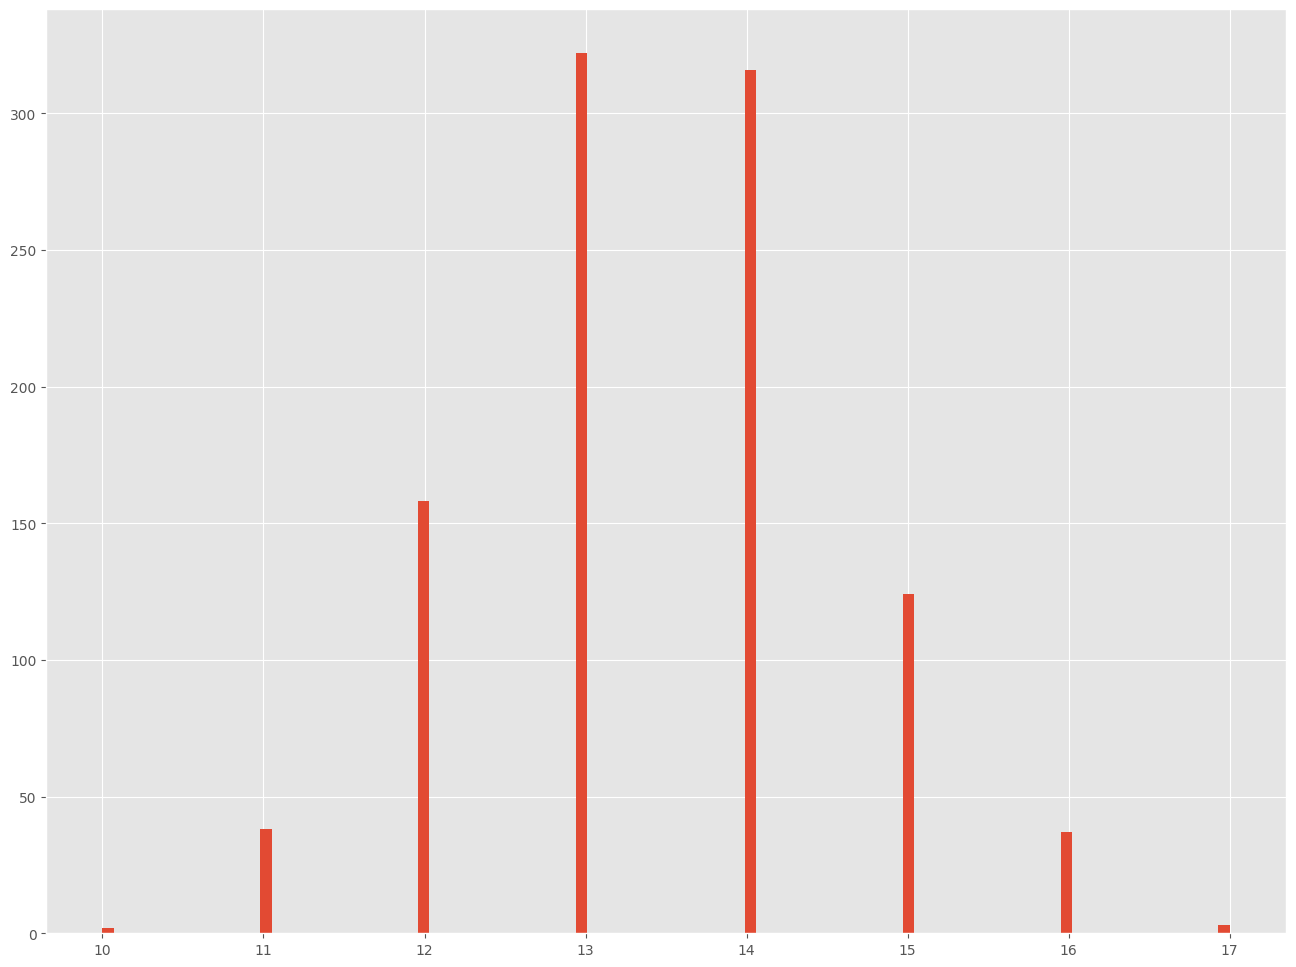

In [242]:
bev_registrations_data_samples.iloc[:, 1].hist(bins=100)

# Estimating On-Plot Parking

In [17]:
class AccommodationTypeCounter:
    def __init__(self, accommodation_type_df, houses_df):
        self.df = accommodation_type_df
        self.houses = houses_df
        self.data = None

    def count(self) -> pd.DataFrame:
        types_data = [
            self._filter_by_type('Detached', 'detached'),
            self._filter_by_type('Semi-detached', 'semi_detached'),
            self._filter_by_type('Terraced', 'terraced'),
            self._filter_by_type('In a purpose-built block of flats or tenement', 'purpose_built_flat'),
            self._combine_converted_flats()
        ]
        concatenated = pd.concat(types_data, axis=1)
        # Group by index and calculate mean (for LSOA21CDs that share a LSOA11CD)
        mean = concatenated.groupby(concatenated.index).mean()
        proportions = mean.div(mean.sum(axis=1), axis=0)
        accommodation_type_counts = round(proportions.mul(self.houses['households'], axis=0))

        # Need to drop duplicates
        self.data = accommodation_type_counts
        
        return accommodation_type_counts

    def _filter_by_type(self, accommodation_type: str, new_name: str) -> pd.Series:
        result = self.df[self.df['accommodation_type'] == accommodation_type]['Observation']
        result.name = new_name
        return result

    def _combine_converted_flats(self):
        types = [
            'Part of a converted or shared house, including bedsits',
            'Part of another converted building, for example, former school, church or warehouse',
            'In a commercial building, for example, in an office building, hotel or over a shop'
        ]
        return sum([self._filter_by_type(atype, 'converted_flat') for atype in types])

In [18]:
accommodation_type_counter = AccommodationTypeCounter(accomodation_type_2021_data, house_2021_data)
accommodation_type_counts = accommodation_type_counter.count()
accommodation_type_counts.head()

,detached,semi_detached,terraced,purpose_built_flat,converted_flat
LSOA11CD,,,,,
E01000001,0.0,3.0,13.0,804.0,18.0
E01000002,1.0,2.0,29.0,768.0,24.0
E01000003,1.0,0.0,0.0,994.0,22.0
E01000005,0.0,0.0,2.0,458.0,20.0
E01000006,34.0,88.0,284.0,121.0,27.0


In [19]:
class OnPlotParkingEstimator:
    def __init__(self, accommodation_type_counts: pd.DataFrame, n_samples: int):
        self.accommodation_type_counts = accommodation_type_counts
        self.n_samples = n_samples
        self.dict = {
            'end_terraced': 0.505,
            'mid_terraced': 0.338,
            'semi_detached': 0.822,
            'detached': 0.961,
            'converted_flat': 0.289,
            'purpose_built_flat': 0.256
            }
        self.dict['terraced'] = round(0.3765*self.dict['end_terraced'] + 0.6235*self.dict['mid_terraced'], 3)
        del self.dict['end_terraced']
        del self.dict['mid_terraced']
        self.series = pd.Series(self.dict)
        self.on_plot_parking_samples = None
    
    def estimate(self):
        # Convert series values to a 2D array with matching shape
        probabilities = self.series[self.accommodation_type_counts.columns].values[np.newaxis, :]
        
        # Generate samples for each accommodation type and LSOA using broadcasting
        samples = binom.rvs(n=self.accommodation_type_counts.values.astype(int),
                            p=probabilities,
                            size=(self.n_samples, *self.accommodation_type_counts.shape))
        
        # Sum across accommodation types (axis 2)
        summed_samples = samples.sum(axis=2)
        
        # Convert summed_samples to a DataFrame with appropriate columns and index
        on_plot_parking_df = pd.DataFrame(summed_samples, columns=self.accommodation_type_counts.index)
        
        self.on_plot_parking_samples = on_plot_parking_df
        return on_plot_parking_df

In [20]:
on_plot_parking_estimator = OnPlotParkingEstimator(accommodation_type_counts=accommodation_type_counts,
                                                   n_samples=1000)
on_plot_parking_samples = on_plot_parking_estimator.estimate()
on_plot_parking_samples.head()

LSOA11CD,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,W01001945,W01001947,W01001948,W01001949,W01001950,W01001951,W01001953,W01001954,W01001956,W01001958
0,237,217,277,103,267,381,150,231,134,235,...,197,276,629,271,178,186,379,470,623,231
1,222,208,248,132,264,383,152,249,138,235,...,173,262,631,253,171,189,378,475,623,241
2,203,214,257,108,265,353,155,217,124,241,...,170,240,624,261,156,183,408,478,626,236
3,211,208,230,106,269,350,165,234,150,230,...,189,256,640,251,168,171,373,476,616,260
4,218,215,261,122,247,341,162,229,127,242,...,186,270,618,263,189,158,368,472,627,267


In [70]:
class VehiclesWithOnPlotParkingEstimator:
    def __init__(
            self, 
            on_plot_parking_samples,
            car_van_2021_data,
            car_van_2011_data,
            house_data,
            relative_difference_samples,
            vehicle_registrations_data,
            ) -> None:
        
        self.on_plot_parking_samples = on_plot_parking_samples
        self.car_van_2021_data = car_van_2021_data
        self.car_van_2011_data = car_van_2011_data
        self.house_data = house_data
        self.relative_difference_samples = relative_difference_samples
        self.vehicle_registrations_data = vehicle_registrations_data
        
        self.houses_with_cars = None
        self.cars_per_house_with_car = None
        self.vehicles_with_on_plot_parking_samples = None
        self.proportion_of_vehicles_with_on_plot_parking = None

    def estimate(self, quarter: str):
        """ 
        This function assumes that all on-plot parking spaces are filled before
        off-plot parking is used.
        """
        self._estimate_houses_with_cars()
        self._estimate_proportion_of_vehicles_with_on_plot_parking(quarter)
    
    def _estimate_houses_with_cars(self):
        cars = self.car_van_2021_data['cars']
        houses = self.house_data['households']
        houses_without_cars = self.car_van_2021_data['houses_without_cars']
        
        houses_with_cars = houses - houses_without_cars
        self.cars_per_house_with_car = cars / houses_with_cars
        self.houses_with_cars = houses_with_cars
    
    def _estimate_proportion_of_vehicles_with_on_plot_parking(self, quarter: str):
        vehicle_registrations_data_samples = (1 + self.relative_difference_samples).mul(self.vehicle_registrations_data[quarter], axis=1)  #.round(0)
        self.vehicles_with_on_plot_parking_samples = pd.DataFrame(
            np.minimum(vehicle_registrations_data_samples.values, on_plot_parking_samples.values), # Assumes same dimensions
            index=vehicle_registrations_data_samples.index, 
            columns=vehicle_registrations_data_samples.columns
            )
        self.proportion_of_vehicles_with_on_plot_parking = self.vehicles_with_on_plot_parking_samples/vehicle_registrations_data_samples

In [71]:
vehicles_with_on_plot_parking_estimator = VehiclesWithOnPlotParkingEstimator(on_plot_parking_samples=on_plot_parking_samples,
                                                                             car_van_2011_data=car_van_2011_data,
                                                                             car_van_2021_data=car_van_2021_data,
                                                                             house_data=house_2021_data,
                                                                             relative_difference_samples=relative_difference_samples,
                                                                             vehicle_registrations_data=vehicle_registrations_data)

vehicles_with_on_plot_parking_estimator.estimate(quarter='2023 Q1')

In [72]:
vehicles_with_on_plot_parking_estimator.proportion_of_vehicles_with_on_plot_parking

,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,W01001945,W01001947,W01001948,W01001949,W01001950,W01001951,W01001953,W01001954,W01001956,W01001958
0,0.735757,0.672085,1.0,0.944764,0.584484,0.741616,0.444503,0.574322,0.317102,0.605568,...,0.169561,0.320254,0.412903,0.407785,0.378207,0.401212,0.465805,0.488676,0.509462,0.312207
1,0.700950,0.700212,1.0,1.000000,0.525509,0.746003,0.450134,0.625174,0.339786,0.615189,...,0.145481,0.268507,0.425645,0.373948,0.360025,0.448167,0.455152,0.491883,0.500831,0.320027
2,0.773174,0.808781,1.0,0.989179,0.512204,0.687233,0.462369,0.577771,0.274649,0.709408,...,0.204149,0.236644,0.413294,0.403623,0.337007,0.447875,0.490762,0.511964,0.516555,0.319643
3,0.908078,0.682233,1.0,0.900137,0.540382,0.681501,0.490699,0.561353,0.356195,0.605524,...,0.205030,0.338092,0.453842,0.366696,0.355421,0.433299,0.449849,0.485062,0.506513,0.354209
4,0.812531,0.712490,1.0,1.000000,0.528046,0.664765,0.480039,0.517769,0.303113,0.666762,...,0.177779,0.292489,0.429227,0.401420,0.386336,0.379471,0.443621,0.489392,0.522949,0.366350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.625468,0.747608,1.0,1.000000,0.545818,0.718901,0.436514,0.579849,0.269531,0.772675,...,0.186339,0.273189,0.410942,0.365930,0.346616,0.416494,0.460187,0.461021,0.508725,0.319025
996,0.653194,0.752403,1.0,1.000000,0.498548,0.685490,0.439119,0.536535,0.302891,0.621463,...,0.211607,0.278260,0.430915,0.368575,0.308779,0.503251,0.471586,0.455712,0.528376,0.327517
997,0.751095,0.687189,1.0,1.000000,0.545006,0.720898,0.441683,0.574633,0.302878,0.723163,...,0.199284,0.300742,0.457862,0.394550,0.407677,0.495345,0.468032,0.472827,0.509789,0.342997
998,0.681938,0.721735,1.0,1.000000,0.489760,0.722780,0.407292,0.598160,0.301537,0.679506,...,0.157314,0.317611,0.434228,0.418877,0.321292,0.465809,0.474688,0.482523,0.495437,0.322605


<Axes: >

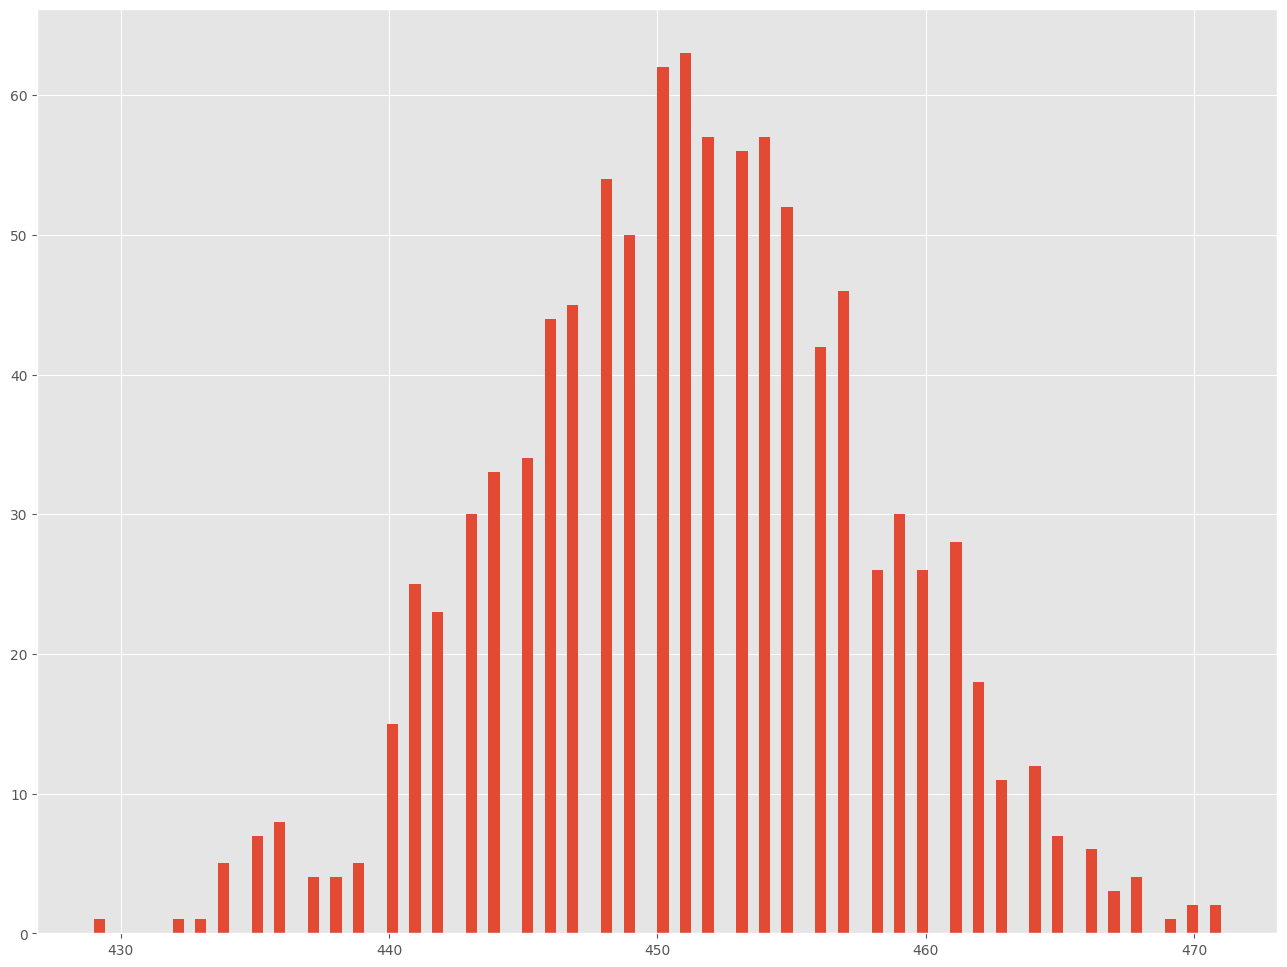

In [74]:
vehicles_with_on_plot_parking_estimator.vehicles_with_on_plot_parking_samples['E01014375'].hist(bins=100)

<Axes: >

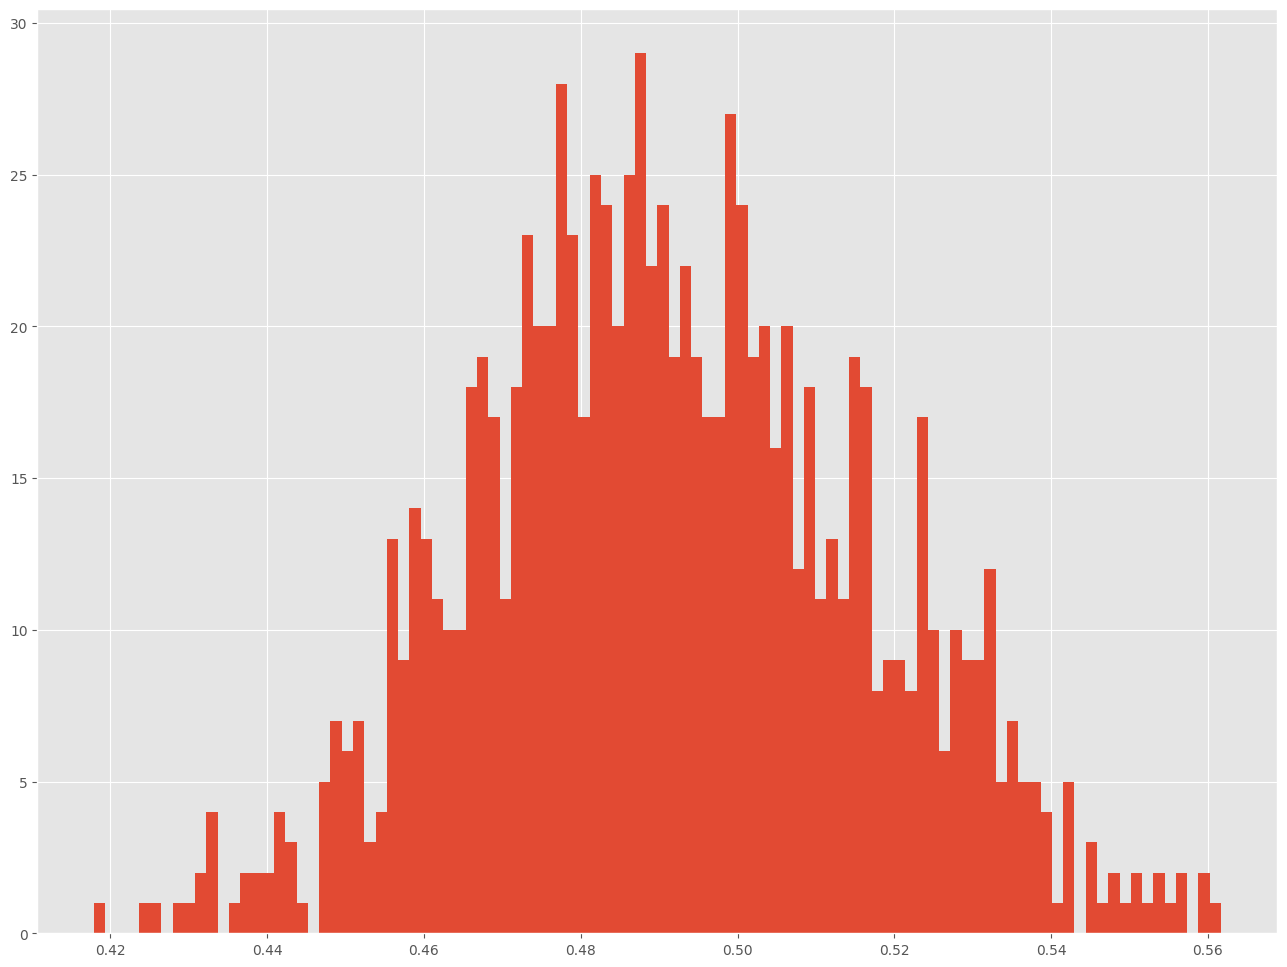

In [75]:
vehicles_with_on_plot_parking_estimator.proportion_of_vehicles_with_on_plot_parking['E01014372'].hist(bins=100)

In [76]:
class EVsWithOnPlotParkingEstimator:
    def __init__(
            self, 
            ev_registrations_data: pd.DataFrame,
            proportion_of_vehicles_with_on_plot_parking: pd.DataFrame
            ) -> None:
        self.vehicle_registrations_data = vehicle_registrations_data
        self.ev_registrations_data = ev_registrations_data
        self.relative_difference_samples = relative_difference_samples
        self.proportion_of_vehicles_with_on_plot_parking = proportion_of_vehicles_with_on_plot_parking

        self.proportion_of_evs_with_on_plot_parking = None
        self.evs_with_on_plot_parking_samples = None

    def estimate(self, quarter: str):
        self._count_evs_with_on_plot_parking(quarter)
        return self.evs_with_on_plot_parking_samples

    def _calculate_proportion_of_evs_with_on_plot_parking(self, mean_total_vehicles, adjusted_ev_registrations_data_samples):
        # Define alpha and beta values for beta distribution that describes likely starting points for EV on-plot parking access
        mu = 0.9 # prior mean
        var = 0.1 * mu*(1-mu)
        alpha = mu*(mu*(1-mu)/var - 1)
        beta = (1-mu)*(mu*(1-mu)/var - 1)

        c = stats.beta.rvs(a=alpha, b=beta, size=(1000, len(self.proportion_of_vehicles_with_on_plot_parking.columns))) # y intercept
        m = (self.proportion_of_vehicles_with_on_plot_parking - c)/mean_total_vehicles # gradient
        p = m*adjusted_ev_registrations_data_samples + c
        return np.clip(p, a_min=0, a_max=1)
        
    def _count_evs_with_on_plot_parking(self, quarter: str):
        # Return proportion of EVs with on-plot parking access. 
        # This changes depending on how many EVs there are relative to the total number of vehicles
        # It approaches the overall proportion for all vehicles.
        
        adjusted_vehicle_registration_data_samples = (1 + self.relative_difference_samples).mul(self.vehicle_registrations_data[quarter], axis=1)
        mean_total_vehicles = adjusted_vehicle_registration_data_samples.mean()
        adjusted_ev_registrations_data_samples = (1 + self.relative_difference_samples).mul(self.ev_registrations_data.loc[quarter], axis=1)
        
        self.proportion_of_evs_with_on_plot_parking = self._calculate_proportion_of_evs_with_on_plot_parking(
            mean_total_vehicles, 
            adjusted_ev_registrations_data_samples.sample(frac=1) # to change the order of the relative differences otherwise they cancel each other out in the next step
            )
        self.evs_with_on_plot_parking_samples = self.proportion_of_evs_with_on_plot_parking.mul(adjusted_ev_registrations_data_samples, axis=1) # .round(0)
        return self.evs_with_on_plot_parking_samples

In [77]:
vehicles_with_on_plot_parking_estimator.proportion_of_vehicles_with_on_plot_parking

,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,W01001945,W01001947,W01001948,W01001949,W01001950,W01001951,W01001953,W01001954,W01001956,W01001958
0,0.735757,0.672085,1.0,0.944764,0.584484,0.741616,0.444503,0.574322,0.317102,0.605568,...,0.169561,0.320254,0.412903,0.407785,0.378207,0.401212,0.465805,0.488676,0.509462,0.312207
1,0.700950,0.700212,1.0,1.000000,0.525509,0.746003,0.450134,0.625174,0.339786,0.615189,...,0.145481,0.268507,0.425645,0.373948,0.360025,0.448167,0.455152,0.491883,0.500831,0.320027
2,0.773174,0.808781,1.0,0.989179,0.512204,0.687233,0.462369,0.577771,0.274649,0.709408,...,0.204149,0.236644,0.413294,0.403623,0.337007,0.447875,0.490762,0.511964,0.516555,0.319643
3,0.908078,0.682233,1.0,0.900137,0.540382,0.681501,0.490699,0.561353,0.356195,0.605524,...,0.205030,0.338092,0.453842,0.366696,0.355421,0.433299,0.449849,0.485062,0.506513,0.354209
4,0.812531,0.712490,1.0,1.000000,0.528046,0.664765,0.480039,0.517769,0.303113,0.666762,...,0.177779,0.292489,0.429227,0.401420,0.386336,0.379471,0.443621,0.489392,0.522949,0.366350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.625468,0.747608,1.0,1.000000,0.545818,0.718901,0.436514,0.579849,0.269531,0.772675,...,0.186339,0.273189,0.410942,0.365930,0.346616,0.416494,0.460187,0.461021,0.508725,0.319025
996,0.653194,0.752403,1.0,1.000000,0.498548,0.685490,0.439119,0.536535,0.302891,0.621463,...,0.211607,0.278260,0.430915,0.368575,0.308779,0.503251,0.471586,0.455712,0.528376,0.327517
997,0.751095,0.687189,1.0,1.000000,0.545006,0.720898,0.441683,0.574633,0.302878,0.723163,...,0.199284,0.300742,0.457862,0.394550,0.407677,0.495345,0.468032,0.472827,0.509789,0.342997
998,0.681938,0.721735,1.0,1.000000,0.489760,0.722780,0.407292,0.598160,0.301537,0.679506,...,0.157314,0.317611,0.434228,0.418877,0.321292,0.465809,0.474688,0.482523,0.495437,0.322605


In [78]:
bevs_with_on_plot_parking_estimator = EVsWithOnPlotParkingEstimator(ev_registrations_data=bev_registrations_data_i,
                                                                   proportion_of_vehicles_with_on_plot_parking=vehicles_with_on_plot_parking_estimator.proportion_of_vehicles_with_on_plot_parking
)

bevs_with_on_plot_parking_estimator.estimate(quarter='2023 Q1')

,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,W01001945,W01001947,W01001948,W01001949,W01001950,W01001951,W01001953,W01001954,W01001956,W01001958
0,8.680902,13.847642,8.128583,0.0,8.182210,4.404025,0.0,0.0,0.0,0.0,...,6.059776,0.0,19.208315,0.0,0.0,0.0,5.185522,13.575763,14.026091,6.796078
1,15.352210,12.826278,9.950250,0.0,7.682028,5.279055,0.0,0.0,0.0,0.0,...,6.485029,0.0,17.953300,0.0,0.0,0.0,5.696213,12.348626,13.507946,6.572051
2,10.185382,11.399485,8.621859,0.0,9.226933,5.317948,0.0,0.0,0.0,0.0,...,4.047010,0.0,20.036567,0.0,0.0,0.0,5.515761,11.809155,11.357697,6.771407
3,11.300432,13.179980,8.265429,0.0,8.562961,3.357218,0.0,0.0,0.0,0.0,...,4.568684,0.0,18.868855,0.0,0.0,0.0,4.742713,13.115689,13.352902,6.985233
4,12.693518,13.184313,7.710933,0.0,7.651298,4.961262,0.0,0.0,0.0,0.0,...,5.850927,0.0,16.889615,0.0,0.0,0.0,5.667275,12.342629,13.829938,6.812986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10.865728,11.924281,9.989922,0.0,8.161763,4.944392,0.0,0.0,0.0,0.0,...,5.136490,0.0,19.697048,0.0,0.0,0.0,5.410828,14.098318,10.081632,5.289232
996,16.244180,11.457272,10.007258,0.0,8.961710,5.305909,0.0,0.0,0.0,0.0,...,4.858118,0.0,15.973350,0.0,0.0,0.0,5.030130,14.055214,13.279208,6.408371
997,12.393536,13.156312,7.749513,0.0,8.492627,5.288657,0.0,0.0,0.0,0.0,...,5.131539,0.0,18.173356,0.0,0.0,0.0,5.733501,12.224130,12.629144,6.391503
998,14.493110,12.304566,8.070044,0.0,8.848072,5.050848,0.0,0.0,0.0,0.0,...,6.228085,0.0,20.033185,0.0,0.0,0.0,5.740027,13.620733,12.591012,7.234500


In [79]:
adjusted_bev_registrations_data_samples = (1 + relative_difference_samples).mul(bev_registrations_data_i.loc['2023 Q1'], axis=1)
adjusted_bev_registrations_data_samples

,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,W01001945,W01001947,W01001948,W01001949,W01001950,W01001951,W01001953,W01001954,W01001956,W01001958
0,16.052354,14.350028,10.744390,0.0,8.239111,5.442189,0.0,0.0,0.0,0.0,...,6.549165,0.0,21.174141,0.0,0.0,0.0,5.803464,13.679622,14.296017,7.100713
1,15.783032,13.202358,10.029231,0.0,9.060786,5.438590,0.0,0.0,0.0,0.0,...,6.703258,0.0,20.605589,0.0,0.0,0.0,5.923625,13.735010,14.542372,7.227082
2,13.084096,11.759810,9.817628,0.0,9.331357,5.441249,0.0,0.0,0.0,0.0,...,4.694062,0.0,20.985907,0.0,0.0,0.0,5.929818,13.279626,14.167606,7.085640
3,11.579347,13.550284,8.765234,0.0,8.978290,5.440382,0.0,0.0,0.0,0.0,...,5.196254,0.0,19.600998,0.0,0.0,0.0,5.914170,13.957477,14.217692,7.044434
4,13.370300,13.411488,9.671664,0.0,8.436602,5.433935,0.0,0.0,0.0,0.0,...,5.897655,0.0,20.012611,0.0,0.0,0.0,5.916812,13.717741,14.016726,6.994350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,16.651978,12.543717,10.364501,0.0,9.252359,5.437323,0.0,0.0,0.0,0.0,...,5.324215,0.0,21.376643,0.0,0.0,0.0,5.874305,14.685320,14.017972,7.400178
996,16.784389,12.522842,10.326886,0.0,9.261362,5.439636,0.0,0.0,0.0,0.0,...,5.247873,0.0,20.547116,0.0,0.0,0.0,5.898688,14.419455,13.806396,6.944586
997,15.326467,13.387883,9.062102,0.0,8.670463,5.436960,0.0,0.0,0.0,0.0,...,5.572378,0.0,19.459259,0.0,0.0,0.0,5.897761,14.348711,14.034578,6.743088
998,17.026910,14.286558,9.544076,0.0,9.243418,5.437457,0.0,0.0,0.0,0.0,...,6.951529,0.0,20.838480,0.0,0.0,0.0,5.935279,14.148818,14.582724,7.437061


<Axes: >

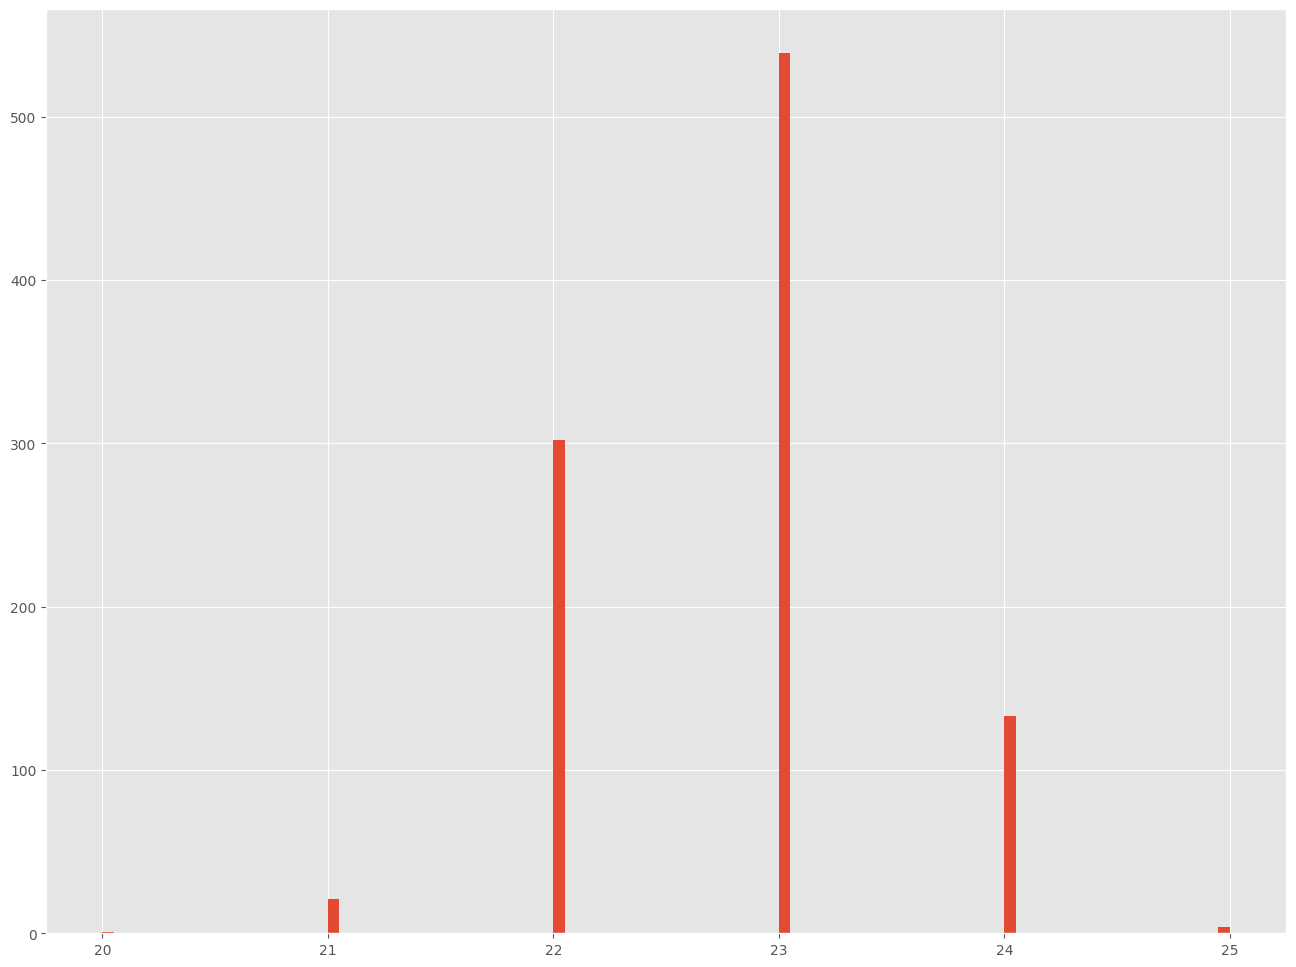

In [80]:
adjusted_bev_registrations_data_samples['E01014374'].round(0).hist(bins=100)

<Axes: >

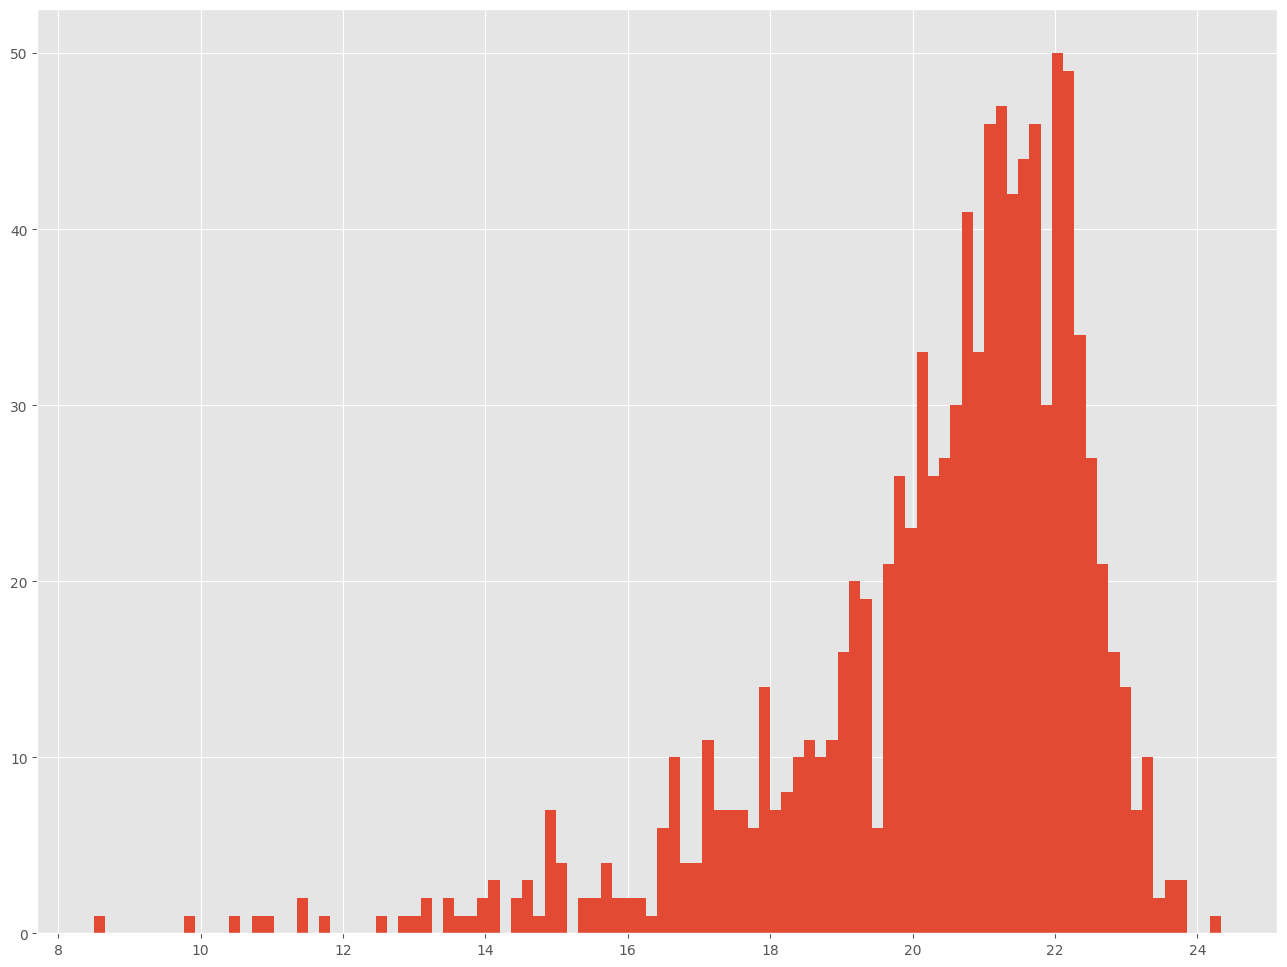

In [81]:
bevs_with_on_plot_parking_estimator.evs_with_on_plot_parking_samples['E01014374'].hist(bins=100)

<Axes: ylabel='Density'>

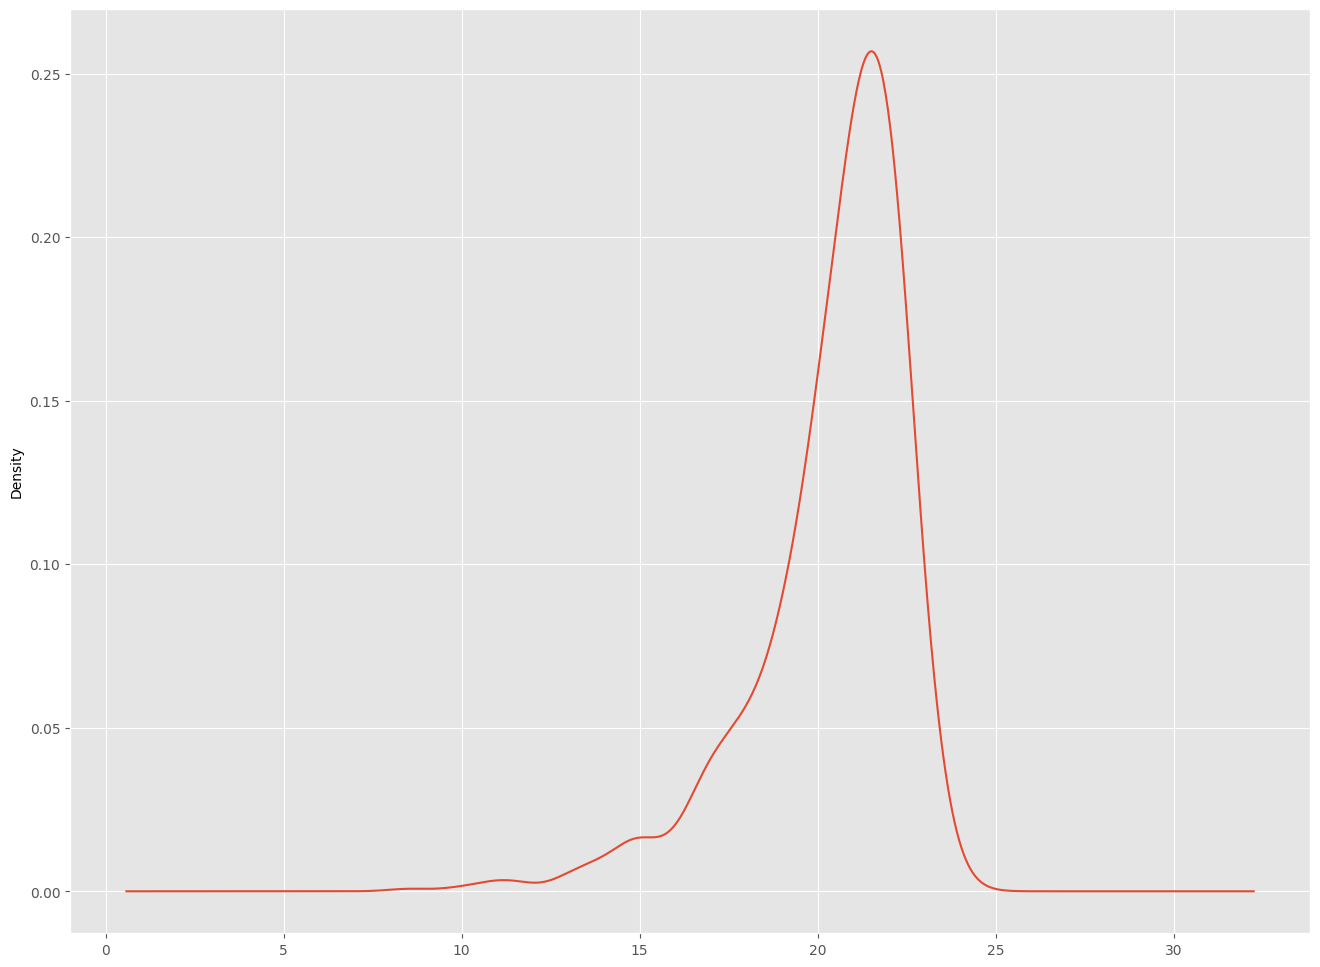

In [82]:
bevs_with_on_plot_parking_estimator.evs_with_on_plot_parking_samples['E01014374'].plot.kde()

In [32]:
# class EVOnPlotParkingEstimator:
#     def __init__(
#         self, 
#         raw_car_van_2021_data, 
#         car_van_2021_data, 
#         car_van_2011_data, 
#         house_data, 
#         vehicle_registrations_data,
#         ev_registrations_data,
#         n_samples,
#         accommodation_type_counts_by_lsoa_data,
#         relative_difference_samples   
#         ):

#         self.on_plot_parking_by_accommodation_type_data = {
#             'end_terraced': 0.505,
#             'mid_terraced': 0.338,
#             'semi_detached': 0.822,
#             'detached': 0.961,
#             'converted_flat': 0.289,
#             'purpose_built_flat': 0.256
#             }
#         self.on_plot_parking_by_accommodation_type_data['terraced'] = round(
#             0.3765*self.on_plot_parking_by_accommodation_type_data['end_terraced'] 
#             + 0.6235*self.on_plot_parking_by_accommodation_type_data['mid_terraced'], 
#             3
#             )
#         del self.on_plot_parking_by_accommodation_type_data['end_terraced']
#         del self.on_plot_parking_by_accommodation_type_data['mid_terraced']
#         self.on_plot_parking_by_accommodation_type_series = pd.Series(self.on_plot_parking_by_accommodation_type_data)
#         self.evs_with_on_plot_parking_data = None

#         self.raw_car_van_2021_data = raw_car_van_2021_data
#         self.car_van_2021_data = car_van_2021_data
#         self.car_van_2011_data = car_van_2011_data
#         self.house_data = house_data
#         self.vehicle_registrations_data = vehicle_registrations_data
#         self.ev_registrations_data = ev_registrations_data
#         self.n_samples = n_samples
#         self.accommodation_type_counts_by_lsoa_data = accommodation_type_counts_by_lsoa_data
#         self.relative_difference_samples = relative_difference_samples  

#         self.car_van_2021_lsoa_codes = set(self.car_van_2021_data.index)
#         self.car_van_2011_lsoa_codes = set(self.car_van_2011_data.index)
#         self.raw_car_van_2021_lsoa_codes = set(self.raw_car_van_2021_data['Lower Layer Super Output Areas Code'].values)       
            
#     def estimate_evs_with_on_plot_parking(self, lsoa_list: list, quarter: str):
#         evs_with_on_plot_parking_dict = {}

#         for lsoa in lsoa_list:
#             if lsoa in self.car_van_2021_lsoa_codes:
#                 census_cars = self.car_van_2021_data.at[lsoa, 'cars']
#             elif lsoa in self.car_van_2011_lsoa_codes:
#                 census_cars = self.car_van_2011_data.at[lsoa, 'cars']

#             on_plot_parking_spaces_samples = self._count_on_plot_parking_spaces(lsoa)
            
#             vehicles_with_on_plot_parking = self._count_vehicles_with_on_plot_parking(lsoa, on_plot_parking_spaces_samples)

#             relative_difference_samples = self.relative_difference_samples[lsoa]

#             adjusted_vehicle_registration_data_samples = (self.vehicle_registrations_data.at[lsoa, quarter] * (1 + relative_difference_samples)).round(0)

#             mean_total_vehicles = adjusted_vehicle_registration_data_samples.mean(), 

#             n_evs = np.random.choice(
#                 (self.ev_registrations_data.at[quarter, lsoa] * (1 + relative_difference_samples)).round(0), 
#                 size=self.n_samples
#                 )
            
#             evs_with_on_plot_parking = self._count_evs_with_on_plot_parking(
#                 vehicles_with_on_plot_parking, 
#                 census_cars, 
#                 mean_total_vehicles, 
#                 n_evs
#                 )

#             evs_with_on_plot_parking_dict[lsoa] = evs_with_on_plot_parking

#             self.evs_with_on_plot_parking_data = pd.DataFrame(evs_with_on_plot_parking_dict)   
    
#     def _count_on_plot_parking_spaces(self, lsoa: str):
#         on_plot_parking_spaces_samples = np.sum(
#             binom.rvs(
#                 n=[self.accommodation_type_counts_by_lsoa_data.loc[lsoa].loc[x].astype(int) for x in self.on_plot_parking_by_accommodation_type_series.index.values], 
#                 p=self.on_plot_parking_by_accommodation_type_series.values.tolist(),
#                 size=(self.n_samples, 5)
#                 ),
#             axis=1
#             )
#         return on_plot_parking_spaces_samples

#     def _count_vehicles_with_on_plot_parking(self, lsoa, on_plot_parking_spaces_samples):
#         """ 
#         This function assumes that all on-plot parking spaces are filled before
#         off-plot parking is used.
#         """
#         if lsoa in self.raw_car_van_2021_lsoa_codes:
#             df = self.raw_car_van_2021_data[self.raw_car_van_2021_data['Lower Layer Super Output Areas Code'] == lsoa]
#         else:
#             df = None

#         if lsoa in self.car_van_2021_data.index:
#             cars = self.car_van_2021_data.at[lsoa, 'cars']
#             houses = self.house_data.at[lsoa, 'households']
#             if df is None:
#                 houses_without_cars = self.car_van_2011_data.at[lsoa, 'households_without_cars']
#             else:
#                 houses_without_cars = df[df['Car or van availability (5 categories) Code'] == 0].Observation.iloc[0]

#         # If the LSOA doesn't show up in the 2021 census, use the 2011 census
#         else:
#             cars = self.car_van_2011_data.at[lsoa, 'cars']
#             houses = self.car_van_2011_data.at[lsoa, 'households']
#             houses_without_cars = self.car_van_2011_data.at[lsoa, 'households_without_cars']

#         houses_with_cars = houses - houses_without_cars
#         # Mean cars per household (of houses that own at least 1 car)
#         cars_per_house_with_car = cars / houses_with_cars

#         houses_with_cars_samples = houses_with_cars * (1 + self.relative_difference_samples[lsoa]) / cars_per_house_with_car

#         vehicles_with_on_plot_parking_samples = (
#             np.clip(
#                 np.random.choice(houses_with_cars_samples, size=self.n_samples), 
#                 a_min=0, 
#                 a_max=on_plot_parking_spaces_samples
#                 ) * cars_per_house_with_car
#             ).round(0).astype(int)

#         return vehicles_with_on_plot_parking_samples
    
#     def _calculate_proportion_of_evs_with_on_plot_parking(self, proportion_of_vehicles_with_on_plot_parking, mean_total_vehicles, n_evs):
#         # Define alpha and beta values for beta distribution that describes likely starting points for EV on-plot parking access
#         mu = 0.9 # prior mean
#         var = 0.1 * mu*(1-mu)
#         alpha = mu*(mu*(1-mu)/var - 1)
#         beta = (1-mu)*(mu*(1-mu)/var - 1)

#         c = stats.beta.rvs(a=alpha, b=beta, size=self.n_samples) # y intercept
#         m = (proportion_of_vehicles_with_on_plot_parking - c)/mean_total_vehicles # gradient
#         p = m*n_evs + c
#         return np.clip(p, a_min=0, a_max=1)
        
#     def _count_evs_with_on_plot_parking(self, vehicles_with_on_plot_parking, census_cars, mean_total_vehicles, n_evs):
#         # Proportion of cars with on-plot parking
#         proportion_of_vehicles_with_on_plot_parking = np.clip(vehicles_with_on_plot_parking/census_cars, a_min=0, a_max=1)

#         # Return proportion of EVs with on-plot parking access. 
#         # This changes depending on how many EVs there are relative to the total number of vehicles
#         # It approaches the overall proportion for all vehicles.
#         proportion_of_evs_with_on_plot_parking = self._calculate_proportion_of_evs_with_on_plot_parking(
#             proportion_of_vehicles_with_on_plot_parking, 
#             mean_total_vehicles, 
#             n_evs
#             )
#         evs_with_on_plot_parking_samples = (proportion_of_evs_with_on_plot_parking * n_evs).round(0)
#         return evs_with_on_plot_parking_samples

# Fitting Distributions to the Probabilistic Estimates

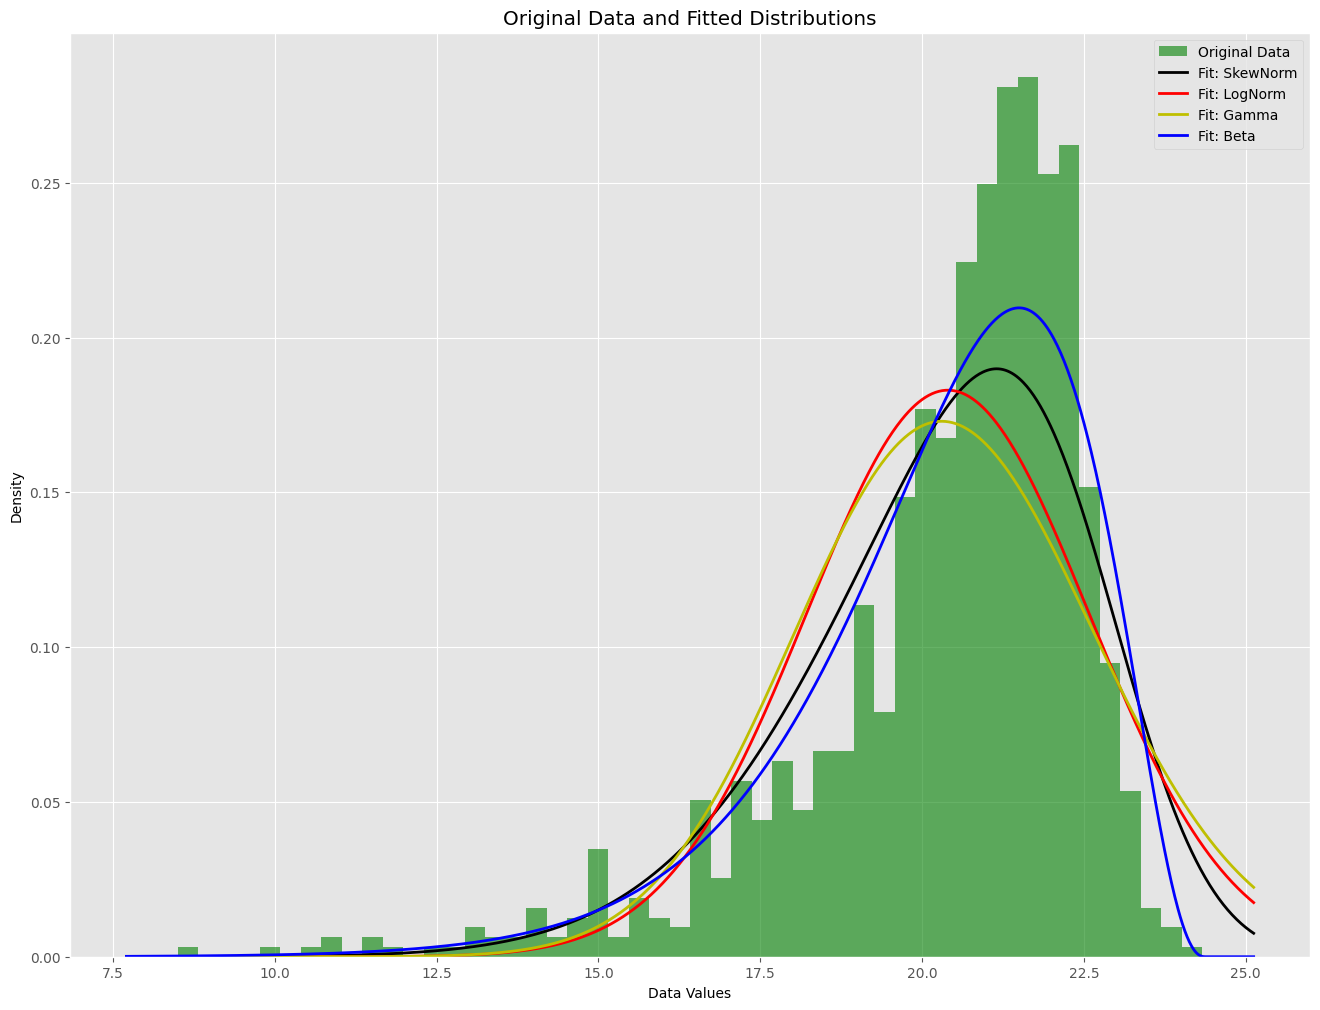

In [124]:
from scipy.stats import skewnorm, lognorm, gamma, beta

data = bevs_with_on_plot_parking_estimator.evs_with_on_plot_parking_samples['E01014374']

params_skewnorm = skewnorm.fit(data)
params_lognorm = lognorm.fit(data)
params_gamma = gamma.fit(data)
params_beta = beta.fit(data)

plt.hist(data, bins=50, density=True, alpha=0.6, color='g', label='Original Data')

# Create an array over which you'll compute the PDFs
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)

# Plot the PDFs using the parameters obtained from the fit
plt.plot(x, skewnorm.pdf(x, *params_skewnorm), 'k', linewidth=2, label='Fit: SkewNorm')
plt.plot(x, lognorm.pdf(x, *params_lognorm), 'r', linewidth=2, label='Fit: LogNorm')
plt.plot(x, gamma.pdf(x, *params_gamma), 'y', linewidth=2, label='Fit: Gamma')
plt.plot(x, beta.pdf(x, *params_beta), 'b', linewidth=2, label='Fit: Beta')

plt.legend(loc='best')
plt.xlabel('Data Values')
plt.ylabel('Density')
plt.title('Original Data and Fitted Distributions')
plt.grid(True)
plt.show()

In [125]:
from scipy.stats import kstest

D_skewnorm, p_skewnorm = kstest(data, 'skewnorm', params_skewnorm)
D_lognorm, p_lognorm = kstest(data, 'lognorm', params_lognorm)
D_gamma, p_gamma = kstest(data, 'gamma', params_gamma)
D_beta, p_beta = kstest(data, 'beta', params_beta)

print(f"SkewNorm: D={D_skewnorm}, p={p_skewnorm}")
print(f"LogNorm: D={D_lognorm}, p={p_lognorm}")
print(f"Gamma: D={D_gamma}, p={p_gamma}")
print(f"Beta: D={D_beta}, p={p_beta}")

SkewNorm: D=0.0930162352759632, p=5.5736685491625705e-08
LogNorm: D=0.12426078144889546, p=6.453978227187605e-14
Gamma: D=0.1308441911346367, p=2.181557500413811e-15
Beta: D=0.07160253425953716, p=6.652483480044619e-05


### Cramér–von Mises statistic

In [126]:
import numpy as np
from scipy.stats import skewnorm

def cramer_von_mises_skewnorm(data, params):
    data_sorted = np.sort(data)
    N = len(data_sorted)
    
    # Expected CDF values under the skewed normal distribution
    cdf_theoretical = skewnorm.cdf(data_sorted, *params)
    
    # Observed ECDF values
    i = np.arange(1, N+1)
    ecdf_observed = i / N
    
    # Calculate Cramér–von Mises Statistic
    W2 = 1/12 + np.sum((ecdf_observed - cdf_theoretical)**2)
    
    return W2

params_skewnorm = skewnorm.fit(data)

W2 = cramer_von_mises_skewnorm(data, params_skewnorm)
print(f"Cramér–von Mises Statistic for Skewed Normal: {W2}")

Cramér–von Mises Statistic for Skewed Normal: 3.1970624403093724


In [127]:
import numpy as np
from scipy.stats import skewnorm, cramervonmises

def cramer_von_mises_skewnorm(data):
    # Estimate the parameters of the skewed normal distribution
    a, loc, scale = skewnorm.fit(data)

    # Apply the Cramér–von Mises test
    result = cramervonmises(data, skewnorm.cdf, args=(a, loc, scale))

    return result

data = bevs_with_on_plot_parking_estimator.evs_with_on_plot_parking_samples['E01014374']

cvm_result = cramer_von_mises_skewnorm(data)
print(cvm_result)

CramerVonMisesResult(statistic=3.1346446499125458, pvalue=3.6699911887261294e-08)


### Q-Q Plots

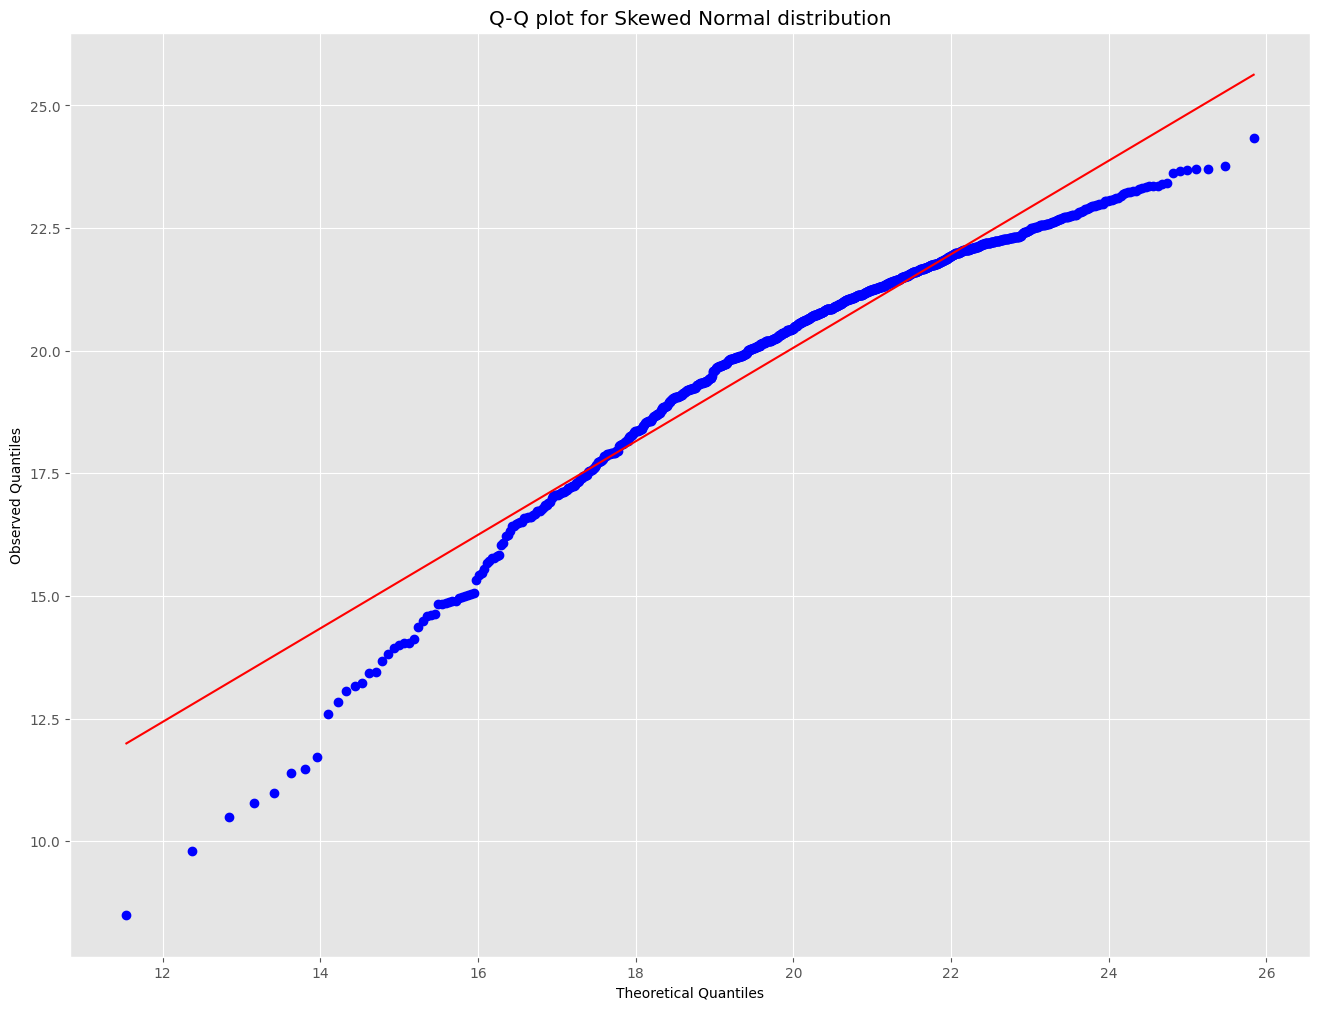

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, probplot

# Using probplot with the skewed normal distribution
osm, osr = probplot(data, dist=skewnorm, sparams=skewnorm.fit(data), plot=plt)

plt.title("Q-Q plot for Skewed Normal distribution")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Observed Quantiles")
plt.show()

In [249]:
vehicle_registrations_data_samples['E01000119']

0      814
1      814
2      814
3      814
4      814
      ... 
995    814
996    814
997    814
998    814
999    814
Name: E01000119, Length: 1000, dtype: Int64

In [ ]:
from scipy.stats import skewnorm

# Assuming 'vehicle_registrations_data' is your DataFrame
# and each column represents a different LSOA with 1000 samples.

# Create an empty DataFrame to store the parameters.
parameters_df = pd.DataFrame(columns=['a', 'loc', 'scale'], index=vehicle_registrations_data_samples.columns)

# Iterate over each column (LSOA) in your DataFrame.
for i, lsoa in enumerate(vehicle_registrations_data_samples.columns):

    print(f"{i} / {len(vehicle_registrations_data_samples.columns)} ")

    # Get the samples for the current LSOA.
    samples = vehicle_registrations_data_samples[lsoa].dropna().astype(float)  # Ensure there are no NaNs.

    if samples.empty:
        print(f"No data available for {lsoa} to fit a distribution.")
        continue  # Skip this LSOA if there's no data.
        
    if np.std(samples) < 1e-5:  # Some small threshold
        print(f"Samples for LSOA {lsoa} have no variation. Skipping fitting.")
        continue
    
    # Fit a skewed normal distribution to the samples.
    # 'a' is the shape parameter, 'loc' is the location (mean), and 'scale' is the scale (standard deviation).
    a_guess = 0  # This means no skew. Adjust if you have better estimates.
    loc_guess = samples.mean()
    scale_guess = samples.std()
    a, loc, scale = skewnorm.fit(samples, loc=loc_guess, scale=scale_guess)
    
    # Store the parameters in the parameters DataFrame.
    parameters_df.loc[lsoa] = [a, loc, scale]

# Display the resulting DataFrame.
print(parameters_df)

In [ ]:
from scipy.stats import skewnorm

# Assuming 'vehicle_registrations_data_samples' is your DataFrame
# and each column represents a different LSOA with 1000 samples.

# Create an empty DataFrame to store the parameters.
parameters_df = pd.DataFrame(columns=['a', 'loc', 'scale'], index=vehicle_registrations_data_samples.columns)

# Define a function to fit the distribution.
def fit_distribution(lsoa):
    samples = vehicle_registrations_data_samples[lsoa].dropna().astype(float)  # Ensure there are no NaNs.

    if samples.empty or np.std(samples) < 1e-5:
        return lsoa, (None, None, None)
    
    loc_guess = samples.mean()
    scale_guess = samples.std()
    a, loc, scale = skewnorm.fit(samples, loc=loc_guess, scale=scale_guess)
    
    return lsoa, (a, loc, scale)

results = []
for i, lsoa in enumerate(vehicle_registrations_data_samples.columns):
    print(f"{i} / {len(vehicle_registrations_data_samples.columns)} ")
    results.append(fit_distribution(lsoa))

# Store the results.
for lsoa, (a, loc, scale) in results:
    parameters_df.loc[lsoa] = [a, loc, scale]

print(parameters_df)

# Creating LSOA Objects

In [ ]:
class LSOA:
    def __init__(self) -> None:
        self.name: str
        self.gis_data: GISData
        self.params: LSOAParams

class GISData:
    def __init__(self) -> None:
        self.latitude:float
        self.longitude:float
        self.boundaries:list[GISBoundary]

class GISBoundary:
    def __init__(self) -> None:
        self.latitudes:list[float]
        self.longitudes:list[float]

class LSOAParams:
    def __init__(self) -> None:
        self.households: str
        self.accommodation_type: dict
        self.on_plot_parking: DataValue
        self.vehicles: DataValue
        self.bevs: DataValue
        self.phevs: DataValue
        self.bevs_with_on_plot_parking: DataValue
        self.phevs_with_on_plot_parking: DataValue

class DataValue:
    def __init__(self) -> None:
        self.mean: float
        self.std: float

# Mapping LSOAs Information to Selected Distribution Substations